In [142]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_lattice as tfl
from keras.layers import Dense
from keras.models import Sequential

df = pd.read_csv("results/output_visualisations.csv")
print(df.head())

   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0           0             0               0                 0   
1           1             1               1                 1   
2           2             2               2                 2   
3           3             3               3                 3   
4           4             4               4                 4   

   Unnamed: 0.1.1.1.1                                           Ref_Wave  \
0                   0  resources/Genspeech/LPCNet_listening_test/mfal...   
1                   1  resources/Genspeech/LPCNet_listening_test/vec1...   
2                   2  resources/Genspeech/LPCNet_listening_test/mfal...   
3                   3  resources/Genspeech/LPCNet_listening_test/vec1...   
4                   4  resources/Genspeech/LPCNet_listening_test/mfal...   

                                           Test_Wave       MOS  warp_q_mfcc  \
0  resources/Genspeech/LPCNet_listening_test/mfal...  3.823139     0.7706

In [143]:
# All 3 scores
df = pd.read_csv("results/Results.csv")
df.sample(frac=1.0, random_state=41).reset_index(drop=True)
batch_size=24
lattice_sizes = [4, 6, 8]
combined_calibrators = tfl.layers.ParallelCombination()
calibrator = tfl.layers.PWLCalibration(
input_keypoints=np.linspace(df['warp_q_mfcc'].min(), df['warp_q_mfcc'].max(), num=5),
dtype=tf.float32,
output_min=0.0,
output_max=lattice_sizes[0] - 1.0,
monotonicity='increasing')
combined_calibrators.append(calibrator)
calibrator = tfl.layers.PWLCalibration(
input_keypoints=np.linspace(df['warp_q_mel'].min(), df['warp_q_mel'].max(), num=5),
dtype=tf.float32,
output_min=0.0,
output_max=lattice_sizes[0] - 1.0,
monotonicity='increasing')
combined_calibrators.append(calibrator)
calibrator = tfl.layers.PWLCalibration(
input_keypoints=np.linspace(df['pesq'].min(), df['pesq'].max(), num=5),
dtype=tf.float32,
output_min=0.0,
output_max=lattice_sizes[0] - 1.0,
monotonicity='increasing')
combined_calibrators.append(calibrator)
lattice = tfl.layers.Lattice(
lattice_sizes=lattice_sizes,
#monotonicities=['increasing', 'increasing', 'increasing'],
output_min=0.0,
output_max=1.0)
model = keras.models.Sequential()
model.add(combined_calibrators)
model.add(lattice)
model.add(Dense(1, activation='linear'))
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adagrad(learning_rate=1.0))
features = df[["warp_q_mfcc","warp_q_mel","pesq"]].values.astype(np.float32)
target = df[["MOS"]].values.astype(np.float32)
model.fit(features,
        target,
        batch_size,
        epochs=256, #FLAGS.num_epochs,
        validation_split=0.2,
        shuffle=False)
results = model.evaluate(features, target, batch_size)
print("test loss", results)
pred_data = df[["warp_q_mfcc","warp_q_mel","pesq"]].values.astype(np.float32)
predictions = model.predict(pred_data)
df["prediction_all"] = predictions

Epoch 1/256
6/6 [==============================] - 1s 28ms/step - loss: 5.5429 - val_loss: 1.2756
Epoch 2/256
6/6 [==============================] - 0s 4ms/step - loss: 0.9992 - val_loss: 1.9617
Epoch 3/256
6/6 [==============================] - 0s 5ms/step - loss: 1.4724 - val_loss: 0.9204
Epoch 4/256
6/6 [==============================] - 0s 4ms/step - loss: 0.4248 - val_loss: 1.7027
Epoch 5/256
6/6 [==============================] - 0s 5ms/step - loss: 0.7063 - val_loss: 1.9198
Epoch 6/256
6/6 [==============================] - 0s 4ms/step - loss: 0.6102 - val_loss: 1.1938
Epoch 7/256
6/6 [==============================] - 0s 5ms/step - loss: 0.2958 - val_loss: 1.3118
Epoch 8/256
6/6 [==============================] - 0s 5ms/step - loss: 0.3412 - val_loss: 1.4087
Epoch 9/256
6/6 [==============================] - 0s 5ms/step - loss: 0.3477 - val_loss: 1.0457
Epoch 10/256
6/6 [==============================] - 0s 5ms/step - loss: 0.2823 - val_loss: 1.0119
Epoch 11/256
6/6 [==========

Pearson:  0.9296170434796809
Spearman:  0.9032263735107117


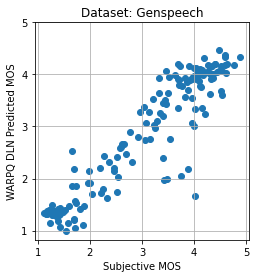

In [144]:
# Compute Pearson correlation coefficient
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(df.MOS,df.prediction_all)
plt.grid(True)
plt.xticks(range(1,6))
plt.yticks(range(1,6))
plt.xlabel('Subjective MOS')
plt.ylabel('WARPQ DLN Predicted MOS')
plt.title('Dataset: Genspeech')
plt.gca().set_aspect('equal')

pearson_coef, p_value = pearsonr(df.MOS,df.prediction_all)
spearman_coef, p_value = spearmanr(df.MOS,df.prediction_all)

print("Pearson: ",pearson_coef)
print("Spearman: ",spearman_coef)

In [145]:
# All MFCC only
batch_size=100
lattice_sizes = [8]
combined_calibrators = tfl.layers.ParallelCombination()
calibrator = tfl.layers.PWLCalibration(
input_keypoints=np.linspace(df['warp_q_mfcc'].min(), df['warp_q_mfcc'].max(), num=5),
dtype=tf.float32,
output_min=0.0,
output_max=lattice_sizes[0] - 1.0,
monotonicity='increasing')
combined_calibrators.append(calibrator)

lattice = tfl.layers.Lattice(
lattice_sizes=lattice_sizes,
#monotonicities=['increasing', 'increasing', 'increasing'],
output_min=0.0,
output_max=1.0)
model = keras.models.Sequential()
model.add(combined_calibrators)
model.add(lattice)
model.add(Dense(1, activation='linear'))
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adagrad(learning_rate=1.0))
features = df[["warp_q_mfcc"]].values.astype(np.float32)
target = df[["MOS"]].values.astype(np.float32)
model.fit(features,
        target,
        batch_size,
        epochs=256, #FLAGS.num_epochs,
        validation_split=0.2,
        shuffle=False)
results = model.evaluate(features, target, batch_size)
print("test loss", results)
pred_data = df[["warp_q_mfcc"]].values.astype(np.float32)
predictions = model.predict(pred_data)
df["prediction_mfcc"] = predictions

Epoch 1/256
2/2 [==============================] - 1s 99ms/step - loss: 7.9033 - val_loss: 4.5929
Epoch 2/256
2/2 [==============================] - 0s 17ms/step - loss: 2.7856 - val_loss: 3.8694
Epoch 3/256
2/2 [==============================] - 0s 17ms/step - loss: 1.7752 - val_loss: 1.1711
Epoch 4/256
2/2 [==============================] - 0s 17ms/step - loss: 0.7082 - val_loss: 1.6159
Epoch 5/256
2/2 [==============================] - 0s 19ms/step - loss: 0.6752 - val_loss: 2.6269
Epoch 6/256
2/2 [==============================] - 0s 18ms/step - loss: 0.8685 - val_loss: 0.8156
Epoch 7/256
2/2 [==============================] - 0s 18ms/step - loss: 0.2900 - val_loss: 1.3069
Epoch 8/256
2/2 [==============================] - 0s 17ms/step - loss: 0.3837 - val_loss: 1.1983
Epoch 9/256
2/2 [==============================] - 0s 17ms/step - loss: 0.3277 - val_loss: 1.2233
Epoch 10/256
2/2 [==============================] - 0s 17ms/step - loss: 0.3167 - val_loss: 1.1899
Epoch 11/256
2/2 [=

Pearson:  0.9004249157638026
Spearman:  0.8852958756198657


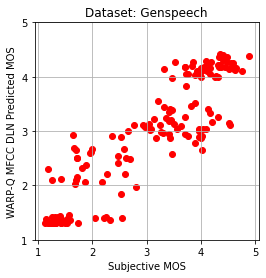

In [146]:
# Compute Pearson correlation coefficient
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(df.MOS,df.prediction_mfcc, c="r")
plt.grid(True)
plt.xticks(range(1,6))
plt.yticks(range(1,6))
plt.xlabel('Subjective MOS')
plt.ylabel('WARP-Q MFCC DLN Predicted MOS')
plt.title('Dataset: Genspeech')
plt.gca().set_aspect('equal')

pearson_coef, p_value = pearsonr(df.MOS,df.prediction_mfcc)
spearman_coef, p_value = spearmanr(df.MOS,df.prediction_mfcc)

print("Pearson: ",pearson_coef)
print("Spearman: ",spearman_coef)

In [147]:
# All MEL + MFCC
batch_size=24
lattice_sizes = [8, 6]
combined_calibrators = tfl.layers.ParallelCombination()
calibrator = tfl.layers.PWLCalibration(
input_keypoints=np.linspace(df['warp_q_mfcc'].min(), df['warp_q_mfcc'].max(), num=5),
dtype=tf.float32,
output_min=0.0,
output_max=lattice_sizes[0] - 1.0,
monotonicity='increasing')
combined_calibrators.append(calibrator)
calibrator = tfl.layers.PWLCalibration(
input_keypoints=np.linspace(df['warp_q_mel'].min(), df['warp_q_mel'].max(), num=5),
dtype=tf.float32,
output_min=0.0,
output_max=lattice_sizes[0] - 1.0,
monotonicity='increasing')
combined_calibrators.append(calibrator)
lattice = tfl.layers.Lattice(
lattice_sizes=lattice_sizes,
#monotonicities=['increasing', 'increasing', 'increasing'],
output_min=0.0,
output_max=1.0)
model = keras.models.Sequential()
model.add(combined_calibrators)
model.add(lattice)
model.add(Dense(1, activation='linear'))
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adagrad(learning_rate=1.0))
features = df[["warp_q_mfcc","warp_q_mel"]].values.astype(np.float32)
target = df[["MOS"]].values.astype(np.float32)
model.fit(features,
        target,
        batch_size,
        epochs=256, #FLAGS.num_epochs,
        validation_split=0.2,
        shuffle=False)
results = model.evaluate(features, target, batch_size)
print("test loss", results)
pred_data = df[["warp_q_mfcc","warp_q_mel"]].values.astype(np.float32)
predictions = model.predict(pred_data)
df["prediction_warpq"] = predictions

Epoch 1/256
6/6 [==============================] - 1s 25ms/step - loss: 3.2736 - val_loss: 3.1158
Epoch 2/256
6/6 [==============================] - 0s 5ms/step - loss: 0.9610 - val_loss: 1.8436
Epoch 3/256
6/6 [==============================] - 0s 5ms/step - loss: 0.3069 - val_loss: 1.5921
Epoch 4/256
6/6 [==============================] - 0s 4ms/step - loss: 0.3901 - val_loss: 1.5537
Epoch 5/256
6/6 [==============================] - 0s 4ms/step - loss: 0.2932 - val_loss: 1.2747
Epoch 6/256
6/6 [==============================] - 0s 4ms/step - loss: 0.3276 - val_loss: 1.1208
Epoch 7/256
6/6 [==============================] - 0s 5ms/step - loss: 0.2378 - val_loss: 0.8189
Epoch 8/256
6/6 [==============================] - 0s 4ms/step - loss: 0.2280 - val_loss: 0.7942
Epoch 9/256
6/6 [==============================] - 0s 4ms/step - loss: 0.2073 - val_loss: 0.7833
Epoch 10/256
6/6 [==============================] - 0s 5ms/step - loss: 0.1983 - val_loss: 0.7810
Epoch 11/256
6/6 [==========

Pearson:  0.922810425617786
Spearman:  0.8971224823821647


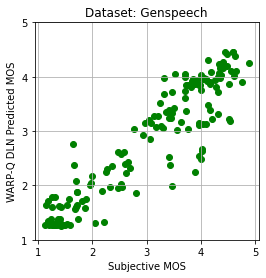

In [148]:
# Compute Pearson correlation coefficient
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(df.MOS,df.prediction_warpq,c="g")
plt.grid(True)
plt.xticks(range(1,6))
plt.yticks(range(1,6))
plt.xlabel('Subjective MOS')
plt.ylabel('WARP-Q DLN Predicted MOS')
plt.title('Dataset: Genspeech')
plt.gca().set_aspect('equal')

pearson_coef, p_value = pearsonr(df.MOS,df.prediction_warpq)
spearman_coef, p_value = spearmanr(df.MOS,df.prediction_warpq)

print("Pearson: ",pearson_coef)
print("Spearman: ",spearman_coef)

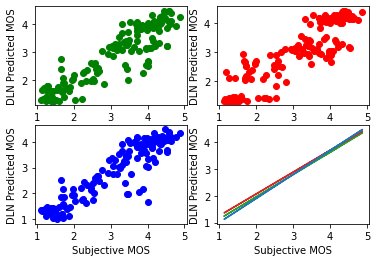

In [152]:
# Compute Pearson correlation coefficient
fig, axs = plt.subplots(2, 2)
#axs = fig.add_subplot(111)
axs[0,0].scatter(df.MOS,df.prediction_warpq,c="g",label="WARP-Q MEL +MFCC")
axs[0,1].scatter(df.MOS,df.prediction_mfcc,c="r",label="WARP-Q MFCC")
axs[1,0].scatter(df.MOS,df.prediction_all,c="b",label="WARP-Q + PESQ")

for ax in axs.flat:
    ax.set(xlabel='Subjective MOS', ylabel='DLN Predicted MOS')

x = df.MOS
y = df.prediction_warpq
m, b = np.polyfit(x, y, 1)
axs[1,1].plot(x, m*x + b, "tab:green")
x = df.MOS
y = df.prediction_mfcc
m, b = np.polyfit(x, y, 1)
axs[1,1].plot(x, m*x + b, "tab:red")
x = df.MOS
y = df.prediction_all
m, b = np.polyfit(x, y, 1)
axs[1,1].plot(x, m*x + b, "tab:blue")
#plt.show()

In [ ]:
axs[0,0].grid(True)
axs[0,1].grid(True)
axs[1,0].grid(True)
axs[1,1].grid(True)

axs[0,0].xticks(range(1,6))
axs[0,1].xticks(range(1,6))
axs[1,0].xticks(range(1,6))
axs[1,1].xticks(range(1,6))

axs[0,0].yticks(range(1,6))
axs[0,1].yticks(range(1,6))
axs[1,0].yticks(range(1,6))
axs[1,1].yticks(range(1,6))

axs[0,0].xlabel('Subjective MOS')
axs[0,1].xlabel('Subjective MOS')
axs[1,0].xlabel('Subjective MOS')
axs[1,1].xlabel('Subjective MOS')

axs[0,0].ylabel('DLN Predicted MOS')
axs[0,1].ylabel('DLN Predicted MOS')
axs[1,0].ylabel('DLN Predicted MOS')
axs[1,1].ylabel('DLN Predicted MOS')

axs[0,0].gca().set_aspect('equal')
axs[0,1].gca().set_aspect('equal')
axs[1,0].gca().set_aspect('equal')
axs[1,1].gca().set_aspect('equal')

axs[0,0].legend(loc='upper left')
axs[0,1].legend(loc='upper left')
axs[1,0].legend(loc='upper left')
axs[1,1].legend(loc='upper left')

axs[0,0].title('Dataset: Genspeech')
axs[0,1].title('Dataset: Genspeech')
axs[1,0].title('Dataset: Genspeech')
axs[1,1].title('Dataset: Genspeech')